<a href="https://colab.research.google.com/github/dariamm03/Machine_Learning/blob/main/MachineLearning3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Необходимо взять не менее 10 значений и построить по ним интерполяционные кривые по формуле Лагранжа, по формуле Ньютона, с использованием сплайнов (интерполяция кубическим сплайном).

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt
from numpy.polynomial import Polynomial

#sklearn import
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
df = pd.read_csv('frequency.csv',sep=",")
df.head(8)

,Timestamp,OAT (F),Power (kW)
0,1/1/2010 1:15,51,165.1
1,1/1/2010 1:30,51,151.6
2,1/1/2010 1:45,51,146.9
3,1/1/2010 2:00,51,153.7
4,1/1/2010 2:15,51,153.8
5,1/1/2010 2:30,51,159.0
6,1/1/2010 2:45,51,157.7
7,1/1/2010 3:00,51,163.2


In [ ]:
price = pd.read_csv('cost.csv',sep="\t")
price.head(8)

,Data,Dollar,Oil Brent
0,01.01.2020,61.9057,66.39
1,09.01.2020,61.9057,65.34
2,10.01.2020,61.2340,65.02
3,11.01.2020,61.2632,64.84
4,14.01.2020,60.9474,64.42
5,15.01.2020,61.4140,64.00
6,16.01.2020,61.4328,64.62
7,17.01.2020,61.5694,64.85


In [ ]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Data       250 non-null    object 
 1   Dollar     250 non-null    float64
 2   Oil Brent  250 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.0+ KB


In [ ]:
df_bmx = df.groupby('OAT (F)')['Power (kW)'].mean().reset_index()

In [ ]:
df_bmx.head(10)

,OAT (F),Power (kW)
0,33,272.825000
1,34,232.332143
2,35,226.925000
3,36,205.828571
4,37,189.505882
5,38,205.391071
6,39,193.540000
7,40,201.919118
8,41,178.243939
9,42,186.268103


**Датасет 2**

In [ ]:
price['Dollar'] = price['Dollar'].astype (int)
price['Oil Brent'] = price['Oil Brent'].astype (int)
price_bmx = price.groupby('Dollar')['Oil Brent'].mean().reset_index()
price.head(8)

,Data,Dollar,Oil Brent
0,01.01.2020,61,66
1,09.01.2020,61,65
2,10.01.2020,61,65
3,11.01.2020,61,64
4,14.01.2020,60,64
5,15.01.2020,61,64
6,16.01.2020,61,64
7,17.01.2020,61,64


In [ ]:
price_bmx.head(10)

,Dollar,Oil Brent
0,60,64.000000
1,61,63.461538
2,62,57.500000
3,63,55.733333
4,64,53.000000
5,65,51.000000
6,66,45.800000
7,67,36.000000
8,68,39.750000
9,69,39.454545


**Интерполяционная кривая по формуле Лагранжа**

In [ ]:
X = np.array(df_bmx['OAT (F)'].values[:10])
Y = np.array(df_bmx['Power (kW)'].values[:10])

n = len(X)
poly = Polynomial(np.zeros(n))

for j in range(n):
    k = [k for k in range(n) if k != j]
    roots = -1 * X[k]

    sub_poly = Polynomial.fromroots(X[k])
    scale = Y[j] / np.prod(X[j] - X[k])
    sub_poly.coef *= scale

    poly.coef += sub_poly.coef

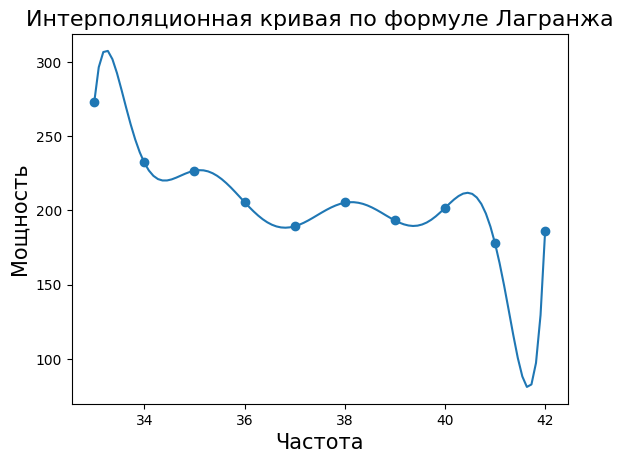

In [ ]:
plt.scatter(X, Y)
Xinterp = np.linspace(min(X), max(X), 100)
plt.plot(Xinterp, poly(Xinterp))
plt.title('Интерполяционная кривая по формуле Лагранжа',size=16)
plt.xlabel('Частота',size=15)
plt.ylabel('Мощность',size=15)
plt.show()

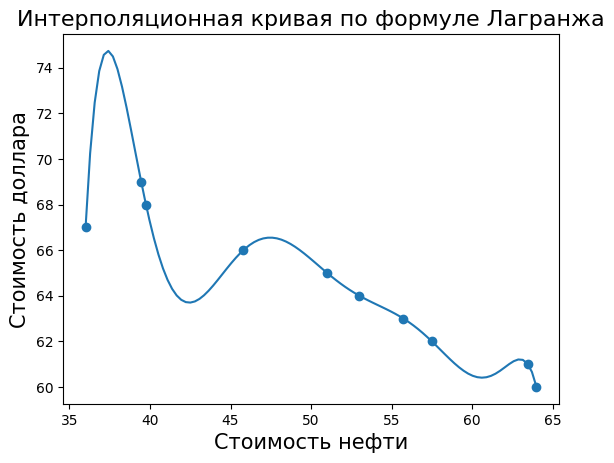

In [ ]:
X = np.array(price_bmx['Oil Brent'].values[:10])
Y = np.array(price_bmx['Dollar'].values[:10])

n = len(X)
poly = Polynomial(np.zeros(n))

for j in range(n):
    k = [k for k in range(n) if k != j]
    roots = -1 * X[k]

    sub_poly = Polynomial.fromroots(X[k])
    scale = Y[j] / np.prod(X[j] - X[k])
    sub_poly.coef *= scale

    poly.coef += sub_poly.coef


plt.scatter(X, Y)
Xinterp = np.linspace(min(X), max(X), 100)
plt.plot(Xinterp, poly(Xinterp))
plt.title('Интерполяционная кривая по формуле Лагранжа',size=16)
plt.xlabel('Стоимость нефти',size=15)
plt.ylabel('Стоимость доллара',size=15)
plt.show()

**Интерполяционные кривые Ньютона**

Text(0, 0.5, 'Мощность')

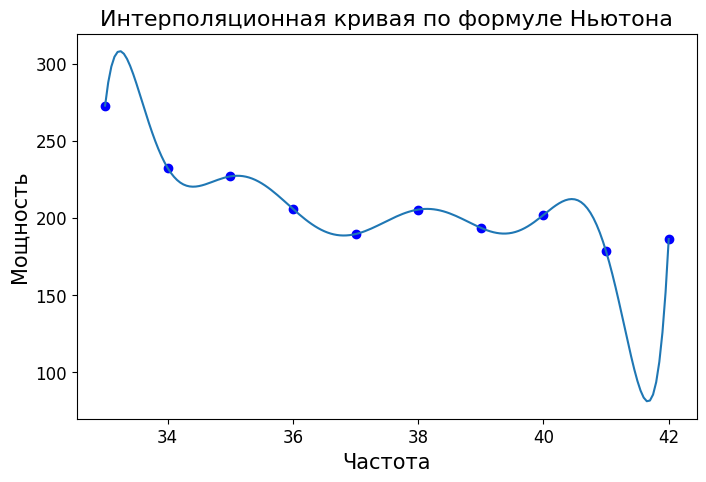

In [ ]:
def divided_diff(x, y): #функция для вычисления разделенной таблицы разностей
    n = len(y)
    coef = np.zeros([n, n])
    coef[:,0] = y #первый столбец - y

    for j in range(1,n):
        for i in range(n-j):
            coef[i][j] = \
           (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j]-x[i])

    return coef


def newton_poly(coef, x_data, x):  #оценить полином Ньютона при x
    n = len(x_data) - 1
    p = coef[n]
    for k in range(1,n+1):
        p = coef[n-k] + (x -x_data[n-k])*p #Интерполяционный многочлен по формуле Ньютона
    return p

x = np.array(df_bmx['OAT (F)'].values[:10])
y = np.array(df_bmx['Power (kW)'].values[:10])
a_s = divided_diff(x, y)[0, :] #получить разделенную разность coef

#оценить по новым точкам данных
x_new = np.arange(33, 42.05, 0.05) #коэффициенты
y_new = newton_poly(a_s, x, x_new)
plt.figure(figsize = (8, 5))
plt.title('Интерполяционная кривая по формуле Ньютона',size=16)
plt.rc('xtick', labelsize= 12)
plt.rc('ytick', labelsize= 12)
plt.plot(x, y, 'bo')
plt.plot(x_new, y_new)
plt.xlabel('Частота',size=15)
plt.ylabel('Мощность',size=15)

Text(0, 0.5, 'Стоимость доллара')

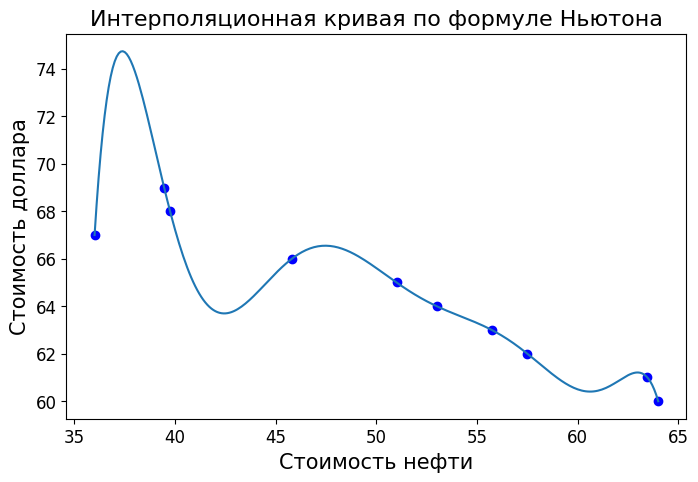

In [ ]:
def divided_diff(x, y):
    n = len(y)
    coef = np.zeros([n, n])
    coef[:,0] = y

    for j in range(1,n):
        for i in range(n-j):
            coef[i][j] = \
           (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j]-x[i])

    return coef


def newton_poly(coef, x_data, x):
    n = len(x_data) - 1
    p = coef[n]
    for k in range(1,n+1):
        p = coef[n-k] + (x -x_data[n-k])*p
    return p

x = np.array(price_bmx['Oil Brent'].values[:10])
y = np.array(price_bmx['Dollar'].values[:10])
a_s = divided_diff(x, y)[0, :]

x_new = np.arange(36, 64.1, 0.1)
y_new = newton_poly(a_s, x, x_new)
plt.figure(figsize = (8, 5))
plt.title('Интерполяционная кривая по формуле Ньютона',size=16)
plt.rc('xtick', labelsize= 12)
plt.rc('ytick', labelsize= 12)
plt.plot(x, y, 'bo')
plt.plot(x_new, y_new)
plt.xlabel('Стоимость нефти',size=15)
plt.ylabel('Стоимость доллара',size=15)

**Интерполяция кубическим сплайном**

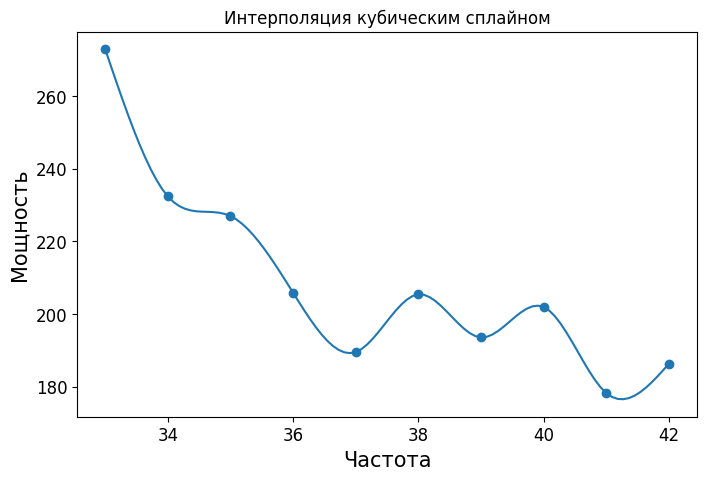

In [ ]:
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt

x = np.array(df_bmx['OAT (F)'].values[:10])
y = np.array(df_bmx['Power (kW)'].values[:10])

#порядок возрастания
if np.any(np.diff(x) < 0):
    indexes = np.argsort(x).astype(int) #Возвращает индексы, по которым будет выполняться сортировка массива
    x = np.array(x)[indexes]
    y = np.array(y)[indexes]

f = CubicSpline(x, y, bc_type='natural')
x_new = np.linspace(min(x), max(x), 100) #коэффициенты
y_new = f(x_new)
plt.figure(figsize = (8, 5))
plt.rc('xtick', labelsize= 12)
plt.rc('ytick', labelsize= 12)
plt.plot(x_new, y_new)
plt.scatter(x, y)
plt.title('Интерполяция кубическим сплайном')
plt.xlabel('Частота',size=15)
plt.ylabel('Мощность',size=15)
plt.show()

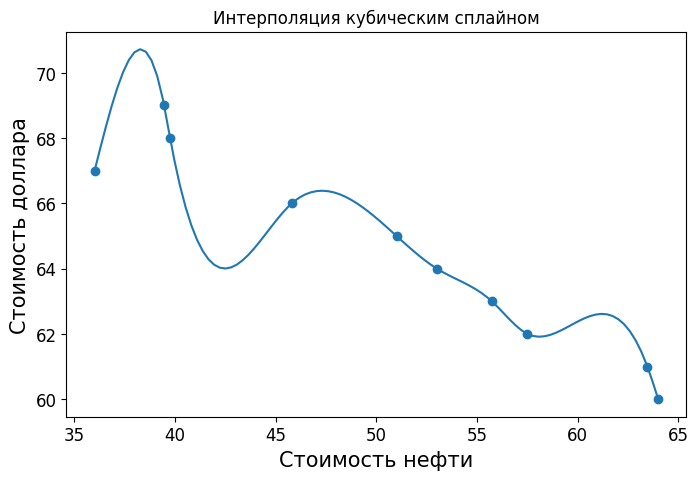

In [ ]:
x = np.array(price_bmx['Oil Brent'].values[:10])
y = np.array(price_bmx['Dollar'].values[:10])

if np.any(np.diff(x) < 0):
    indexes = np.argsort(x).astype(int)
    x = np.array(x)[indexes]
    y = np.array(y)[indexes]

f = CubicSpline(x, y, bc_type='natural')
x_new = np.linspace(min(x), max(x), 100)
y_new = f(x_new)
plt.figure(figsize = (8, 5))
plt.rc('xtick', labelsize= 12)
plt.rc('ytick', labelsize= 12)
plt.plot(x_new, y_new)
plt.scatter(x, y)
plt.title('Интерполяция кубическим сплайном')
plt.xlabel('Стоимость нефти',size=15)
plt.ylabel('Стоимость доллара',size=15)
plt.show()